In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%pylab inline
%load_ext autoreload
%autoreload 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pathlib import Path
import pickle
import pandas as pd
from tqdm import tqdm
import networkx as nx
from allensdk.core.cell_types_cache import CellTypesCache

In [3]:
from ssl_neuron.data.data_utils import connect_graph, remove_axon, rotate_cell
from ssl_neuron.utils import neighbors_to_adjacency, plot_neuron

#### Load ids

In [4]:
cell_ids = list(np.load('all_ids.npy'))

#### Load Cell Types Database

In [5]:
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

#### Load table with additional information

In [6]:
# Download link in readme (https://github.com/marissaweis/ssl_neuron/tree/main/ssl_neuron/data).
df = pd.read_csv('41593_2019_417_MOESM5_ESM.csv', delimiter=';', decimal=",")

#### Preprocess cells

In [7]:
for cell_id in tqdm(cell_ids):
    path = Path('./skeletons/', str(cell_id))
    path.mkdir(parents=True, exist_ok=True)

    morphology = ctc.get_reconstruction(cell_id) 
    
    # Rotate respecitve to pia.
    morphology = rotate_cell(cell_id, morphology, df)

    # Get soma coordinates.
    soma = morphology.soma
    soma_pos = np.array([soma['x'], soma['y'], soma['z']])
    soma_id = soma['id']

    # Process graph.
    neighbors = {}
    idx2node = {}
    for i, item in enumerate(morphology.compartment_list):
        # Get node features.
        sec_type = [0, 0, 0, 0]
        sec_type[item['type'] - 1] = 1
        feat = tuple([item['x'], item['y'], item['z'], item['radius']]) + tuple(sec_type)
        idx2node[i] = feat
        
        # Get neighbors.
        neighbors[i] = set(item['children'])
        if item['parent'] != -1:
            neighbors[i].add(item['parent'])

    features = np.array(list(idx2node.values()))
    
    assert ~np.any(np.isnan(features))
    
    # Normalize soma position to origin.
    norm_features = features.copy()
    norm_features[:, :3] = norm_features[:, :3] - soma_pos
    
    # Test if graph is connected.
    adj_matrix = neighbors_to_adjacency(neighbors, range(len(neighbors)))
    G = nx.Graph(adj_matrix)
    if nx.number_connected_components(G) > 1:
        adj_matrix, neighbors = connect_graph(adj_matrix, neighbors, features)
        
    assert len(neighbors) == len(adj_matrix)

    # Remove axons.
    neighbors, norm_features, soma_id = remove_axon(neighbors, norm_features, int(soma_id))

    assert len(neighbors) == len(norm_features)
    assert ~np.any(np.isnan(norm_features))

    np.save(Path(path, 'features'), norm_features)
    with open(Path(path, 'neighbors.pkl'), 'wb') as f:
        pickle.dump(dict(neighbors), f, pickle.HIGHEST_PROTOCOL)

100%|██████████| 430/430 [00:00<00:00, 2636770.06it/s]


#### Visualize neuron

In [8]:
# Load neuronal data.
path = Path('./skeletons/', '485835016')
features = np.load(Path(path, 'features.npy'))
with open(Path(path, 'neighbors.pkl'), 'rb') as f:
    neighbors = pickle.load(f)

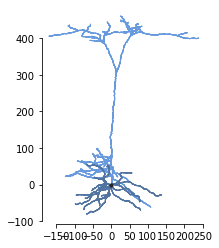

In [9]:
plot_neuron(neighbors, features)